<a href="https://colab.research.google.com/github/vitroid/TileCycles/blob/main/TileCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install genice to generate the structure of ice.
! pip install genice2

## benchmark test

In [1]:
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule

import networkx as nx
import numpy as np
import random
import time



In [2]:
def test_icerule(d, N):
    assert d.number_of_nodes() == N
    for node in d:
        assert d.in_degree(node) == 2
        assert d.in_degree(node) == 2        

## Buch's algorithm

There are two hydrogen sites between two neighboring oxygens, and Buch's algorithm assumes that the initial configuration is one in which all the hydrogens randomly occupy one of the two sites.

In the initial configuration, there are many oxygen atoms with excess hydrogen. The algorithm migrates hydrogen from such an oxygen atom to a neighboring oxygen atom, and repeats the process randomly until there are two hydrogen species in every oxygen atom.


In [17]:
def migrate(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    while len(excess) > 0:
        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)

lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(2,)) # generates an undirected graph
water      = Molecule("spce")
            
buch = []
for NN in range(4,100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N,N,N]).generate_ice(water, formatter)
    g = raw['graph']
    Nnode = g.number_of_nodes()

    delta = 0.0
    Nrep  = 0
    while delta < 25.0 and Nrep < 100:
        dd = nx.DiGraph()
        for a,b in g.edges():
            if random.randint(0,1) == 1:
                dd.add_edge(a,b)
            else:
                dd.add_edge(b,a)

        now = time.time()
        migrate(dd, set([x for x in dd.nodes if dd.out_degree(x)>2]))
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    buch.append([Nnode,delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if delta > 100:
        break

64 molecules 0.0007976794242858887 s avg. 100 reps.
216 molecules 0.0037792372703552247 s avg. 100 reps.
512 molecules 0.010907974243164063 s avg. 100 reps.
1000 molecules 0.026852226257324217 s avg. 100 reps.
1728 molecules 0.05287705898284912 s avg. 100 reps.
4096 molecules 0.17555171251296997 s avg. 100 reps.
8000 molecules 0.46322732943075673 s avg. 54 reps.
13824 molecules 1.3208919449856407 s avg. 19 reps.
32768 molecules 7.883743464946747 s avg. 4 reps.
64000 molecules 31.755836009979248 s avg. 1 reps.
125000 molecules 135.1386969089508 s avg. 1 reps.


## GenIce algorithm

Tiling by cycles.

In [42]:
from collections import defaultdict

def find_cycle(g, chain, order):
    head = chain[-1]
    last = -1
    if len(chain) > 1:
        last = chain[-2]
    while True:
        nexts = [i for i in g[head] if i != last]
        last = head
        head = random.choice(nexts)
        if head in order:
            i = order[head]
            assert i == chain.index(head)
            if i == 0:
                return [], chain
            return chain[:i+1], chain[i:]
        order[head] = len(chain)
        chain.append(head)

        
def remove_cycle(g, cycle, order):
    for i in range(1,len(cycle)):
        del order[cycle[i]]
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        g.remove_edge(a,b)
    for a in cycle:
        if g.degree(a) == 0:
            g.remove_node(a)


def tileByCycles(g):
    chain = []
    while g.number_of_nodes() > 0:
        if len(chain) == 0:
            head  = random.choice(list(g.nodes()))
            chain = [head]
            # "order" stores the order of a node in the chain
            order = dict()
            order[head] = 0
        chain, cycle = find_cycle(g, chain, order)
        yield cycle
        remove_cycle(g, cycle, order)


lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(2,)) # generates an undirected graph
water      = Molecule("spce")

gen  = []
for NN in range(4,100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N,N,N]).generate_ice(water, formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    # 一旦無向グラフになおし、

    delta = 0.0
    Nrep  = 0
    while delta < 25.0 and Nrep < 100:
        g = nx.Graph(g0)

        now = time.time()
        dd = nx.DiGraph()
        for cycle in tileByCycles(g):
            if random.randint(0,1) == 0:
                nx.add_cycle(dd, cycle)
            else:
                nx.add_cycle(dd, cycle[::-1])
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    gen.append([Nnode,delta,Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= 1e6:
        break

64 molecules 0.0005005240440368652 s avg. 100 reps.
216 molecules 0.0016349220275878905 s avg. 100 reps.
512 molecules 0.003937056064605713 s avg. 100 reps.
1000 molecules 0.0077289390563964845 s avg. 100 reps.
1728 molecules 0.014181249141693116 s avg. 100 reps.
4096 molecules 0.0341080641746521 s avg. 100 reps.
8000 molecules 0.08347035408020019 s avg. 100 reps.
13824 molecules 0.15946095705032348 s avg. 100 reps.
32768 molecules 0.3914722725749016 s avg. 64 reps.
64000 molecules 0.9315587591241907 s avg. 27 reps.
125000 molecules 2.035205529286311 s avg. 13 reps.
262144 molecules 5.030002236366272 s avg. 6 reps.
512000 molecules 12.650138020515442 s avg. 2 reps.
1000000 molecules 29.20327877998352 s avg. 1 reps.


## Rahman's algorithm

The algorithm prepares a depolarized structure in advance and generates a hydrogen-disordered structure by successively reversing randomly chosen homodromic cycles.

Here, the ice Ic structure generated by GenIce is used as an initial structure, and the procedure is repeated until all the edges are inverted at least once.

In [18]:
import random

def six(d, Nnode):
    """
    find a cyclic path in the given digraph.
    d: digraph (networkx.DiGraph)
    """
    head = random.randint(0, Nnode-1)
    path = [head]
    while True:
        nexts = list(d.neighbors(head))
        next = random.choice(nexts)
        if next in path:
            i = path.index(next)
            return path[i:]
        path.append(next)
        head = next

def invertCycle(d, cycle, g):
    for i in range(len(cycle)):
        a, b = cycle[i-1], cycle[i]
        d.remove_edge(a,b)
        d.add_edge(b,a)
        # footprint
        if g.has_edge(a,b):
            g.remove_edge(a,b)


lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(3,)) # We need the directed graph of ice!
water      = Molecule("spce")

rahman  = []
for N in range(1,20):
    raw = GenIce(lattice, rep=[N,N,N]).generate_ice(water, formatter)
    d = nx.DiGraph(raw['digraph'].edges())
    Nnode = d.number_of_nodes()

    delta = 0.0
    Nrep  = 0
    while delta < 25.0 and Nrep < 100:
        # footprint
        g = nx.Graph(d)

        now = time.time()
        while g.number_of_edges() > 0:
            cycle = six(d, d.number_of_nodes())
            invertCycle(d, cycle, g)
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    rahman.append([Nnode,delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(d, Nnode)
    if delta > 50:
        break


8 molecules 0.00042351756640064144 s avg. 4723 reps.
64 molecules 0.0059551504396256946 s avg. 336 reps.
216 molecules 0.04169024030367533 s avg. 48 reps.
512 molecules 0.1640445085672232 s avg. 13 reps.
1000 molecules 0.3777349392573039 s avg. 6 reps.
1728 molecules 0.9683992862701416 s avg. 3 reps.
2744 molecules 2.4667809009552 s avg. 1 reps.
4096 molecules 4.229054927825928 s avg. 1 reps.
5832 molecules 8.157728910446167 s avg. 1 reps.
8000 molecules 21.52269196510315 s avg. 1 reps.
10648 molecules 30.895194053649902 s avg. 1 reps.
13824 molecules 56.96268081665039 s avg. 1 reps.


Text(0, 0.5, 'Time / s')

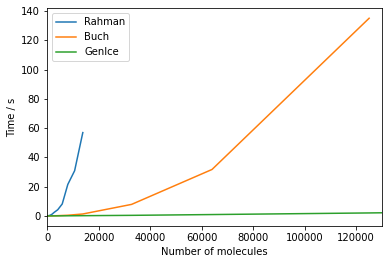

In [44]:
from matplotlib import pyplot as plt


buch = np.array(buch)
gen  = np.array(gen)
rahman = np.array(rahman)

plt.plot(rahman[:,0], rahman[:,1], label="Rahman")
plt.plot(buch[:,0], buch[:,1], label="Buch")
plt.plot(gen[:,0], gen[:,1], label="GenIce")
plt.xlim(0,130000)
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")



Text(0, 0.5, 'Time / s')

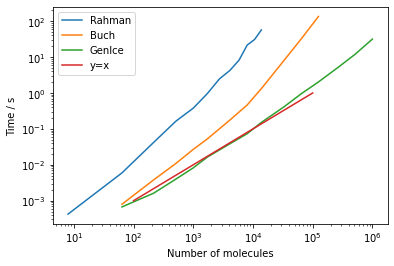

In [37]:
lin = np.linspace(1e2, 1e5,100)
plt.loglog(rahman[:,0], rahman[:,1], label="Rahman")
plt.loglog(buch[:,0], buch[:,1], label="Buch")
plt.loglog(gen[:,0], gen[:,1], label="GenIce")
plt.loglog(lin, lin*1e-5, label="y=x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")
